In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
def prepare_fixed_data(n_digits = 10, latent_size = 10):
    r = torch.randn((n_digits, latent_size))
    result = None
    for i in range(n_digits):
        y = torch.zeros(n_digits,1).long() + i
        y = torch.zeros(n_digits,n_digits).scatter(1,y,1)
        f = torch.cat((r, y), dim=1)
        result = f if result is None else torch.cat((result, f), dim=0)
    return result

In [6]:
fixed_z = prepare_fixed_data(10,10).cuda() #torch.randn((10, 10)).cuda()
fixed_z[:10,:]

tensor([[-0.2522, -0.6203,  1.0580,  1.9714, -0.1693, -0.0865,  1.0680, -0.3681,
          0.2943, -0.4581,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5944, -1.3360,  0.1951, -0.4671,  1.3644,  1.0216, -0.5866,  0.1729,
         -0.6815,  0.7050,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.6394,  0.3404,  0.5266,  0.0491, -0.4953, -0.8180, -1.0683,  0.4095,
          0.7296,  0.4428,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6424, -1.0070,  0.3008, -0.6479,  1.3028, -1.9768,  0.3478, -0.2867,
         -1.2118, -0.3354,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.7176,  0.5011, -0.2510, -0.2106, -0.7796, -0.7356,  0.3668, -1.1598,
          0.1940, -0.0328,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
      

In [7]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_data, fixed_target = next(iter(test_loader))
fixed_data = fixed_data.cuda()
fixed_target = fixed_target.cuda()

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size+10, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x, y):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        onehot = torch.zeros(y.shape[0], 10).cuda().scatter_(1,y[:,None],1)
        x = self.decode(torch.cat((h, onehot), dim=1))
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size]).cuda()
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

In [12]:
models = {'VAE10': Net(10, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4).cuda()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [13]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        for model in models.values():
            model.optim.zero_grad()
            output = model(data, target)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [14]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data = data.cuda()
            target = target.cuda()
            output = {k: m(data, target) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data, fixed_target).data.cpu().numpy()
            fixed_gen = models[k].decode(fixed_z).data.cpu().numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            print("\n======= Decode from fixed sample =======\n")
            plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

/cephfs/home/seliverstov/oml/env/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 1.0224
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.5973
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.4838
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.4377
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.3808
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.3394


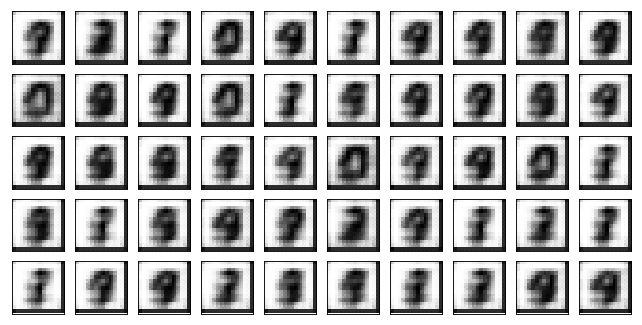


======= Decode from fixed sample =======



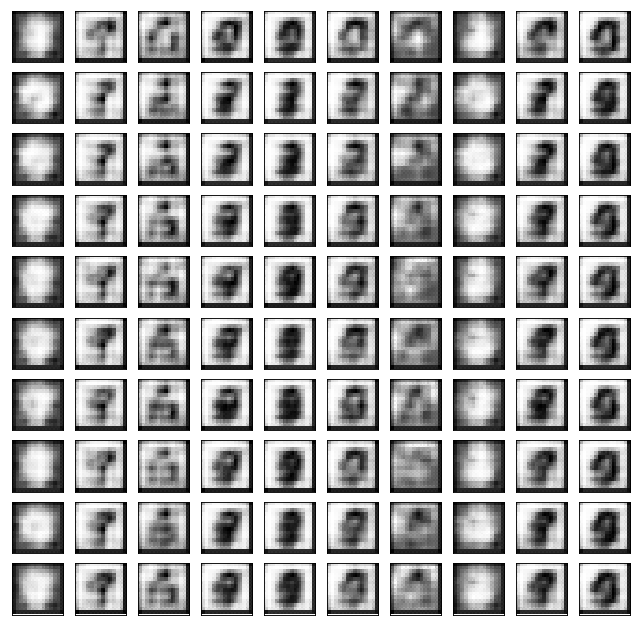

Test losses: VAE10: 0.3445/2.7149
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.3412
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.3209
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.2800
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.2600
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.2328
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.2365


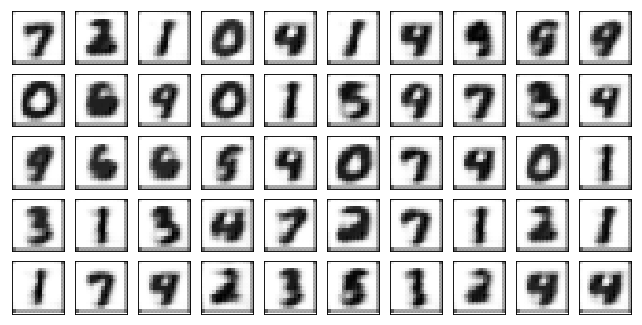


======= Decode from fixed sample =======



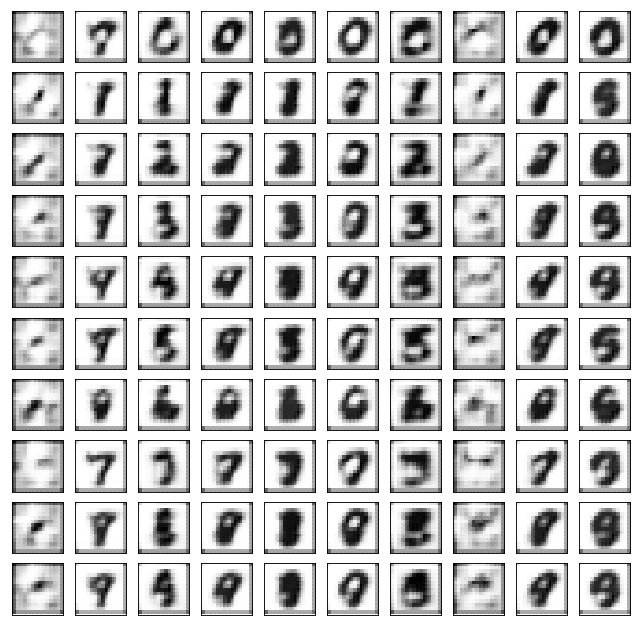

Test losses: VAE10: 0.2206/3.7192
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.2353
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.2228
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.2167
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.2117
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1973
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1873


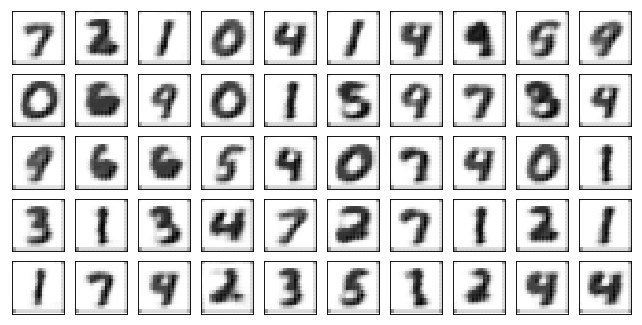


======= Decode from fixed sample =======



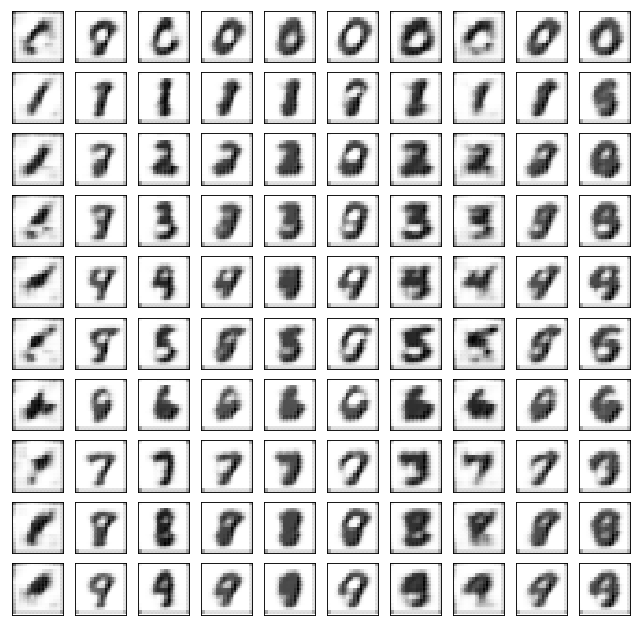

Test losses: VAE10: 0.1853/4.0121
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.2077
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1953
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1699
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.1776
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1792
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1756


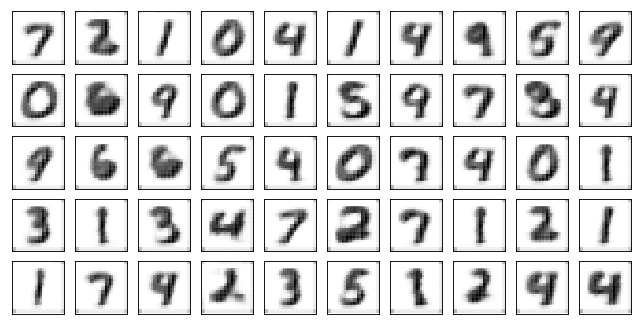


======= Decode from fixed sample =======



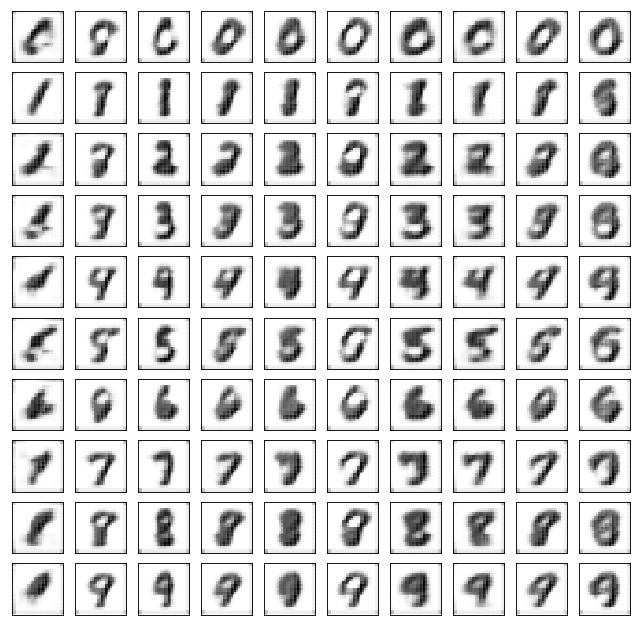

Test losses: VAE10: 0.1617/4.6999
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.1669
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1887
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1777
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1638
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1576
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1461


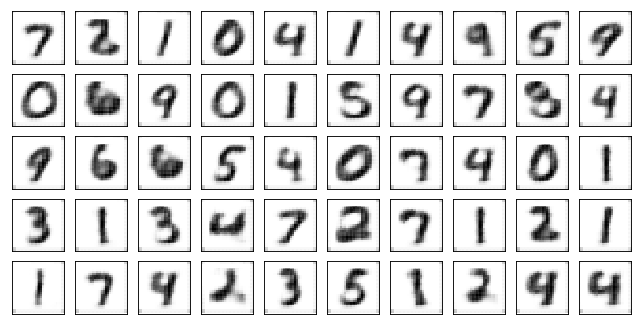


======= Decode from fixed sample =======



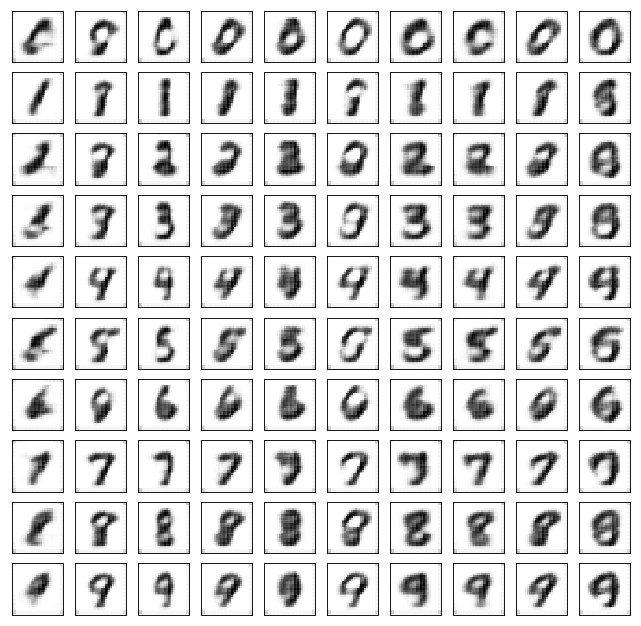

Test losses: VAE10: 0.1391/5.7562
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1598
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1502
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1474
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1458
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1434
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1429


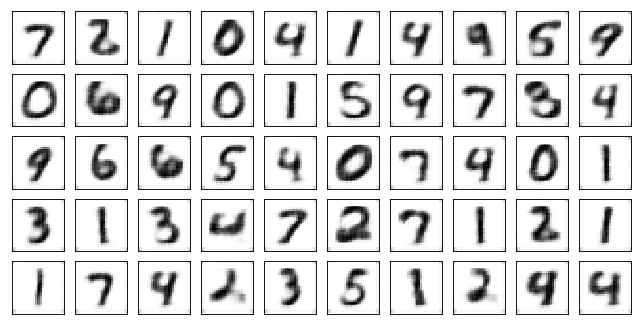


======= Decode from fixed sample =======



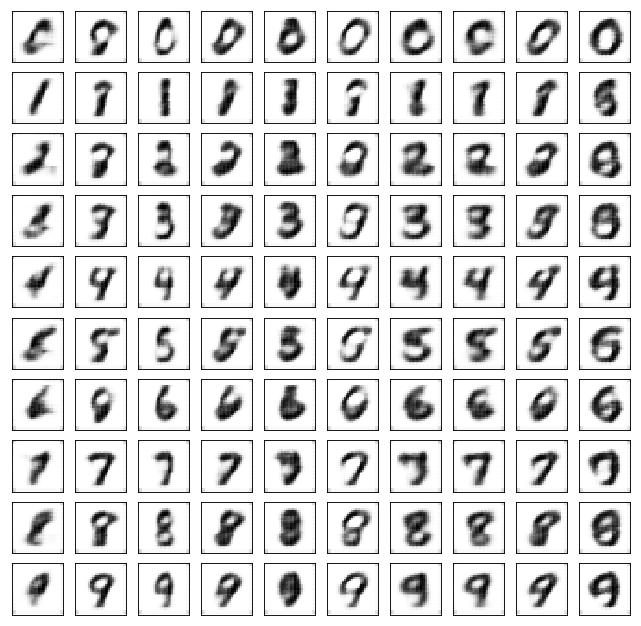

Test losses: VAE10: 0.1243/6.6179
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1542
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1414
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.1344
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1335
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1393
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1205


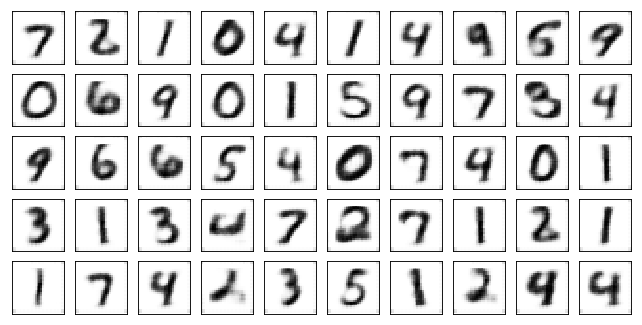


======= Decode from fixed sample =======



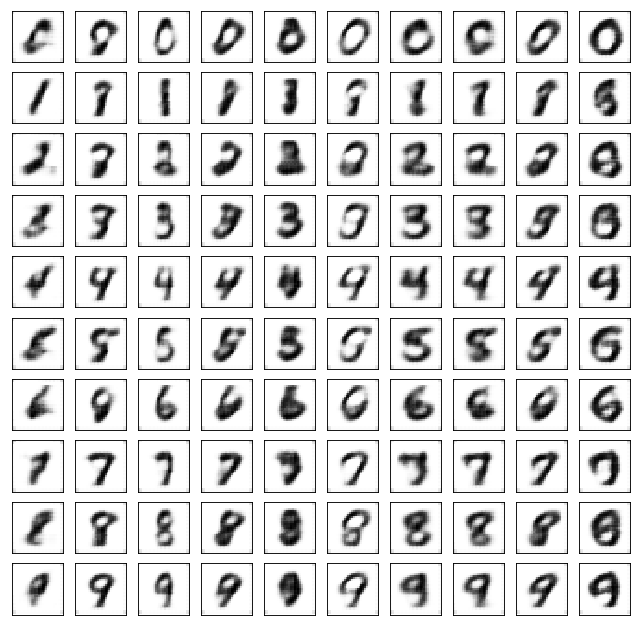

Test losses: VAE10: 0.1146/6.8590
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1357
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1291
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1326
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1289
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1398
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.1283


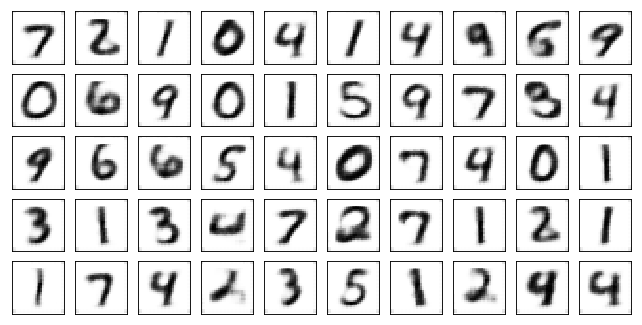


======= Decode from fixed sample =======



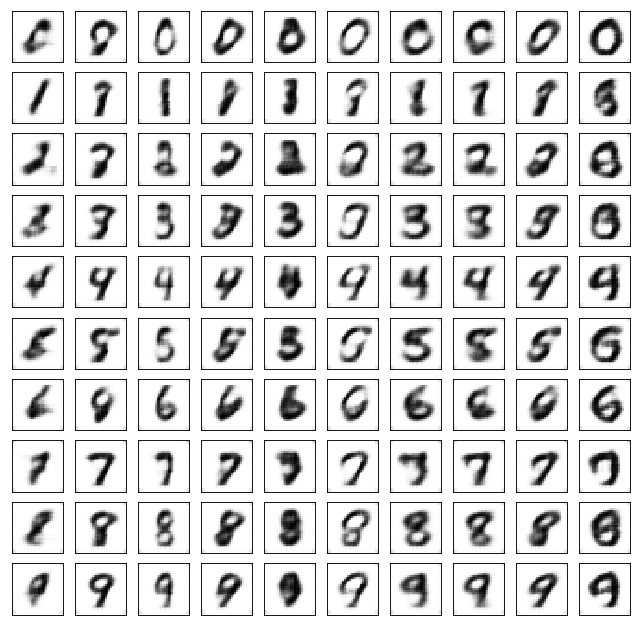

Test losses: VAE10: 0.1091/7.4089
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1308
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1305
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1155
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1394
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1177
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1190


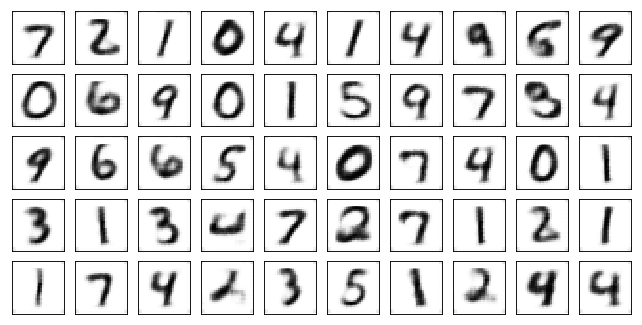


======= Decode from fixed sample =======



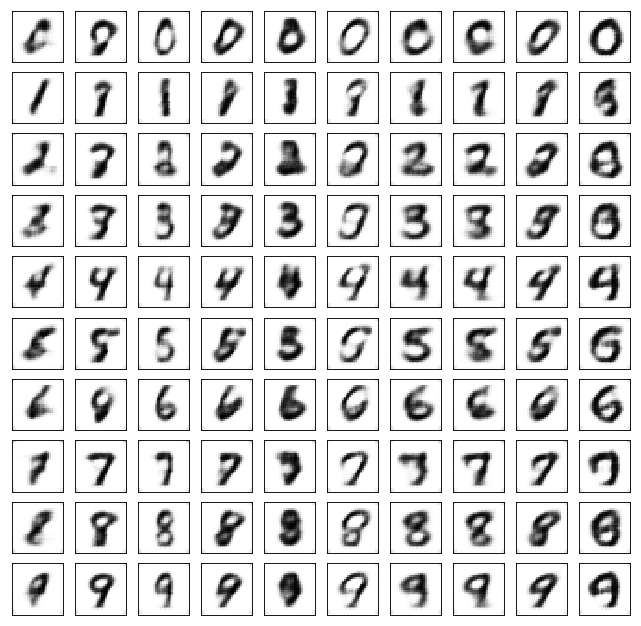

Test losses: VAE10: 0.1038/7.5297
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1332
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1222
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1125
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1201
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.1153
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1233


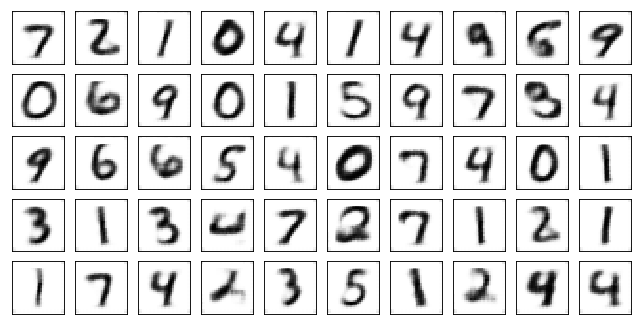


======= Decode from fixed sample =======



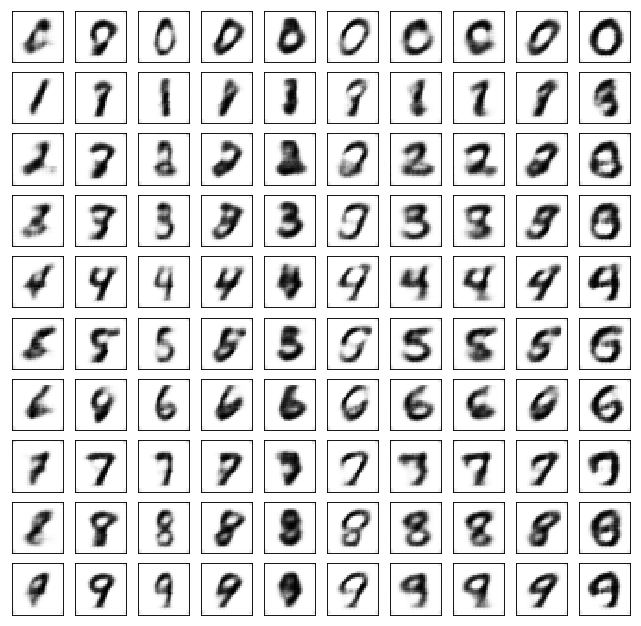

Test losses: VAE10: 0.1003/7.7093
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1151
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE10: 0.1266
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE10: 0.1172
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE10: 0.1295
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE10: 0.1123
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE10: 0.0995


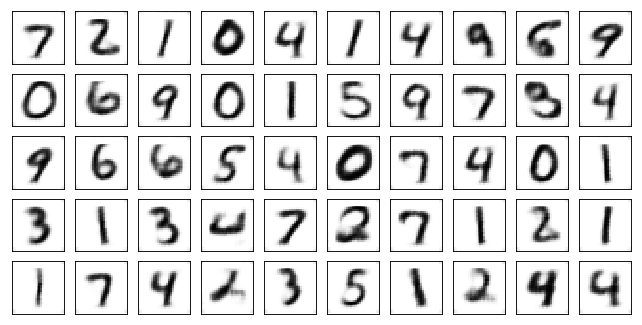


======= Decode from fixed sample =======



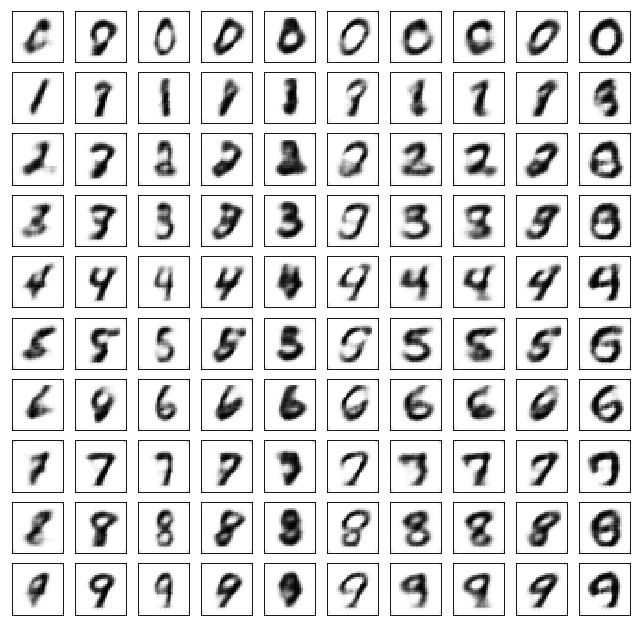

Test losses: VAE10: 0.0977/8.0270
Train Epoch: 12 [0/50000 (0%)]	Losses VAE10: 0.1019
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE10: 0.1124
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE10: 0.1141
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE10: 0.1110
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE10: 0.1111
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE10: 0.1150


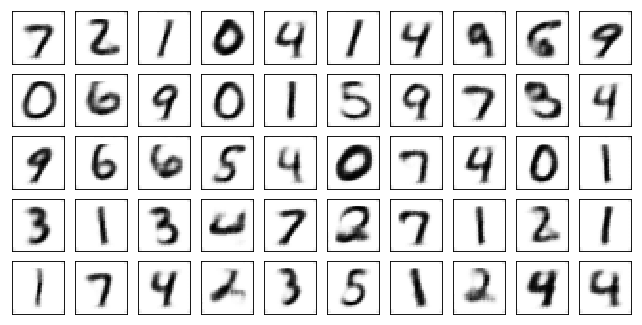


======= Decode from fixed sample =======



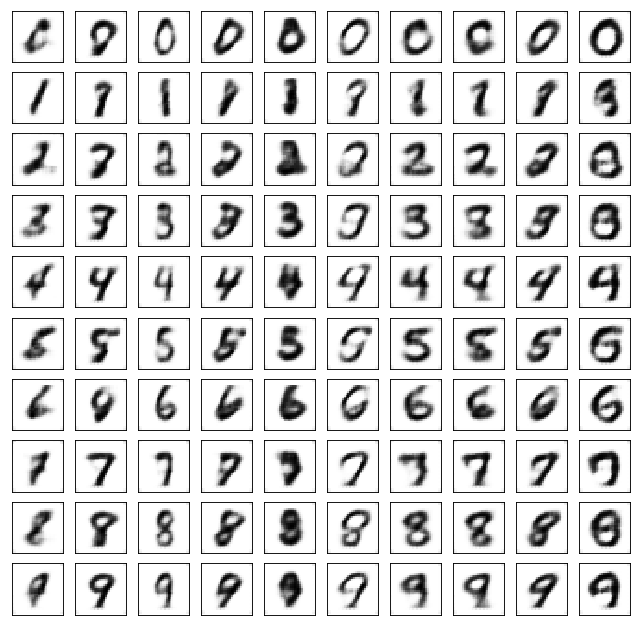

Test losses: VAE10: 0.0954/8.0629
Train Epoch: 13 [0/50000 (0%)]	Losses VAE10: 0.1172
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE10: 0.1155
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE10: 0.1129
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE10: 0.1135
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE10: 0.1162
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE10: 0.1175


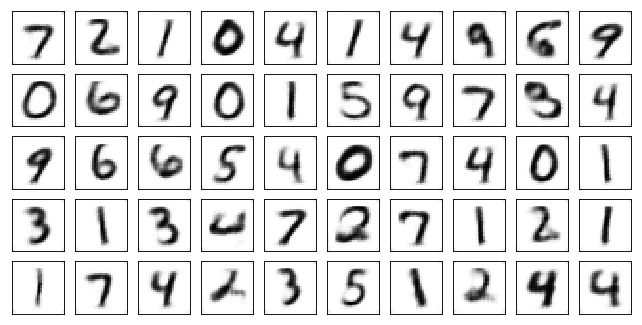


======= Decode from fixed sample =======



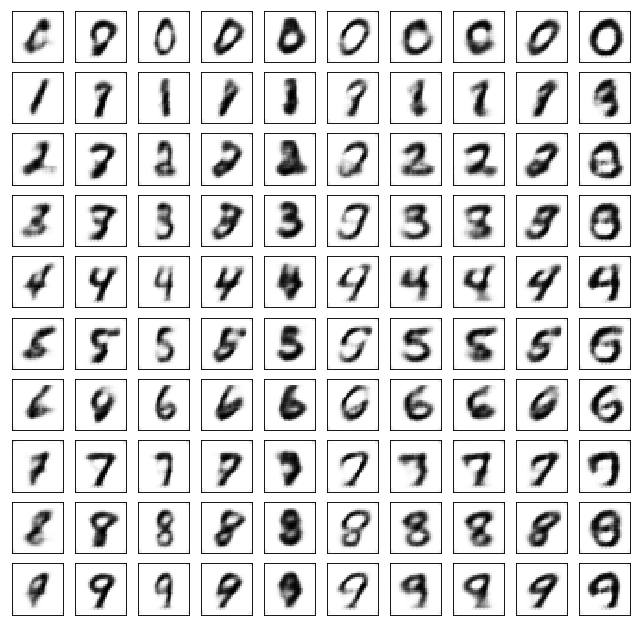

Test losses: VAE10: 0.0931/8.1550
Train Epoch: 14 [0/50000 (0%)]	Losses VAE10: 0.1022
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE10: 0.1080
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE10: 0.1211
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE10: 0.1066
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE10: 0.1086
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE10: 0.1139


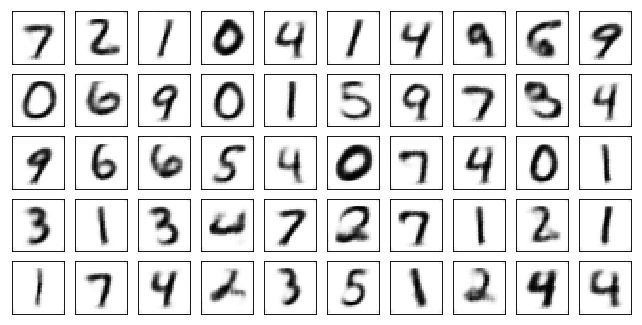


======= Decode from fixed sample =======



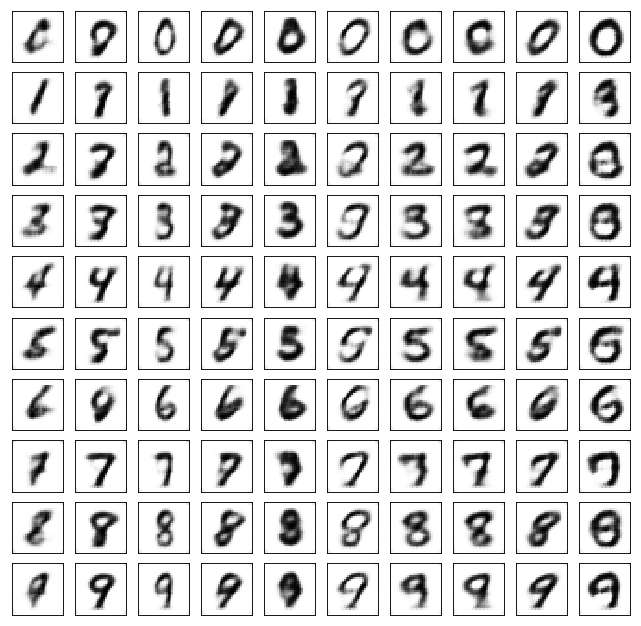

Test losses: VAE10: 0.0916/8.1066
Train Epoch: 15 [0/50000 (0%)]	Losses VAE10: 0.1110
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE10: 0.1086
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE10: 0.1132
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE10: 0.1074
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE10: 0.1040
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE10: 0.1198


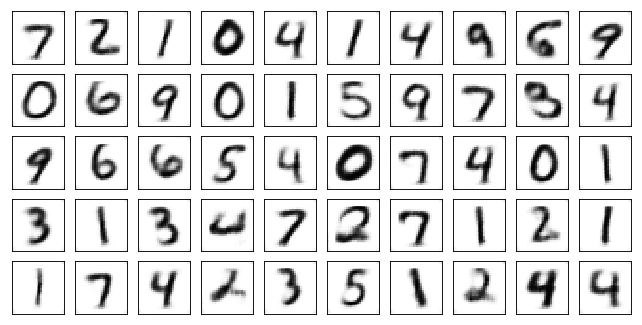


======= Decode from fixed sample =======



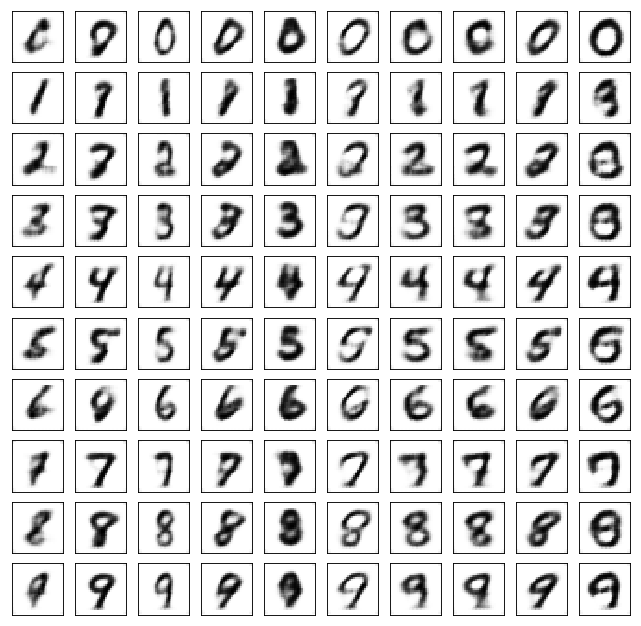

Test losses: VAE10: 0.0900/8.2722
Train Epoch: 16 [0/50000 (0%)]	Losses VAE10: 0.1147
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE10: 0.1094
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE10: 0.1090
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE10: 0.1215
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE10: 0.1121
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE10: 0.1106


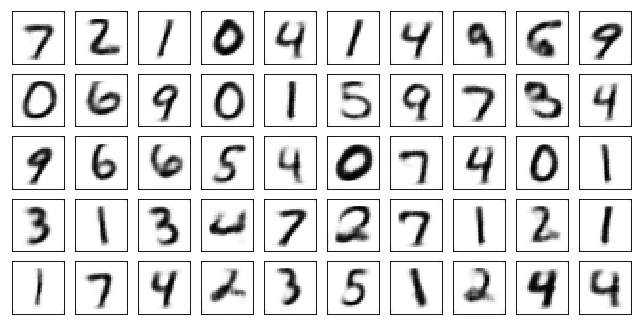


======= Decode from fixed sample =======



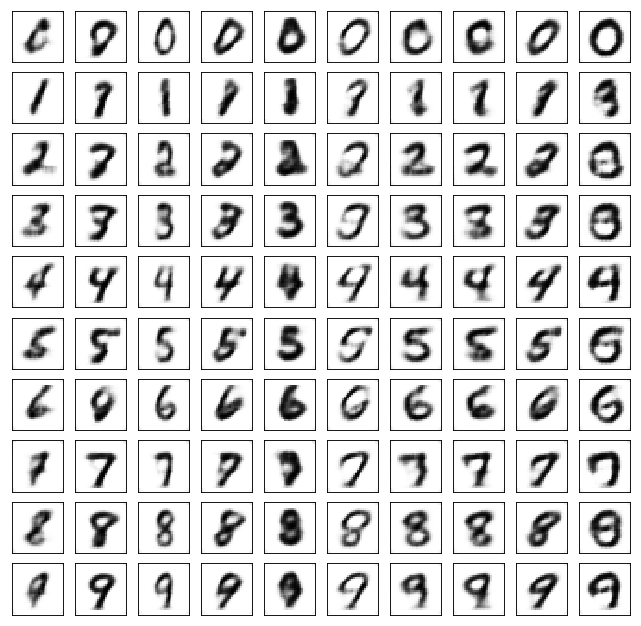

Test losses: VAE10: 0.0885/8.3471
Train Epoch: 17 [0/50000 (0%)]	Losses VAE10: 0.1060
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE10: 0.1027
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE10: 0.1003
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE10: 0.1112
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE10: 0.1017
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE10: 0.1082


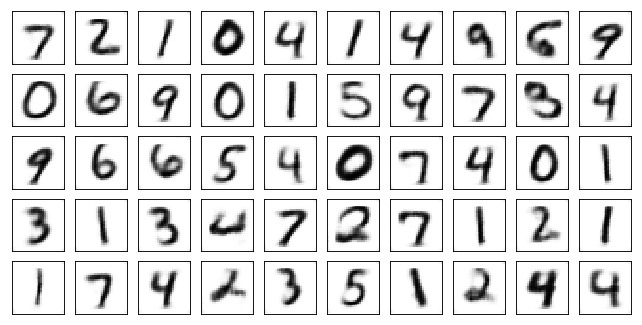


======= Decode from fixed sample =======



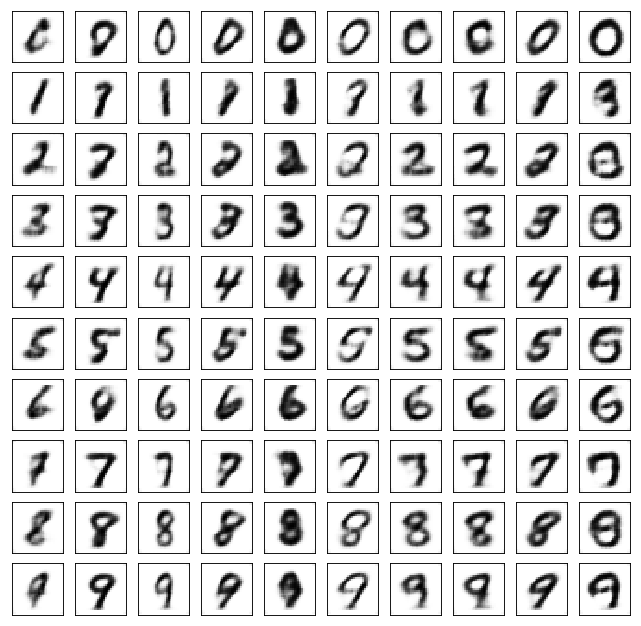

Test losses: VAE10: 0.0870/8.3524
Train Epoch: 18 [0/50000 (0%)]	Losses VAE10: 0.1112
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE10: 0.1034
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE10: 0.1041
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE10: 0.1000
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE10: 0.1089
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE10: 0.1060


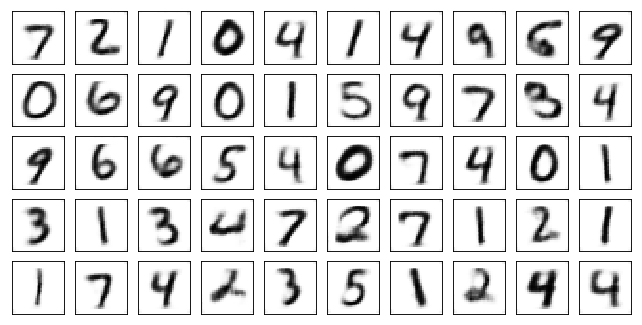


======= Decode from fixed sample =======



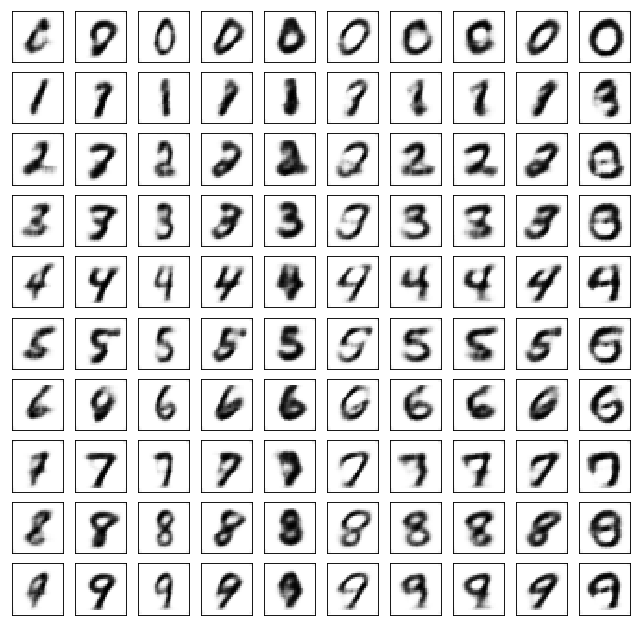

Test losses: VAE10: 0.0863/8.5284
Train Epoch: 19 [0/50000 (0%)]	Losses VAE10: 0.1101
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE10: 0.1051
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE10: 0.1053
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE10: 0.1006
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE10: 0.1144
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE10: 0.1019


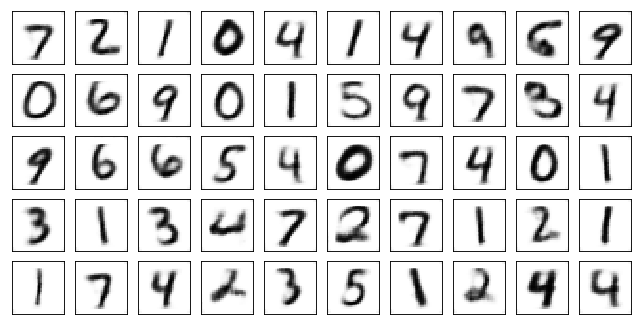


======= Decode from fixed sample =======



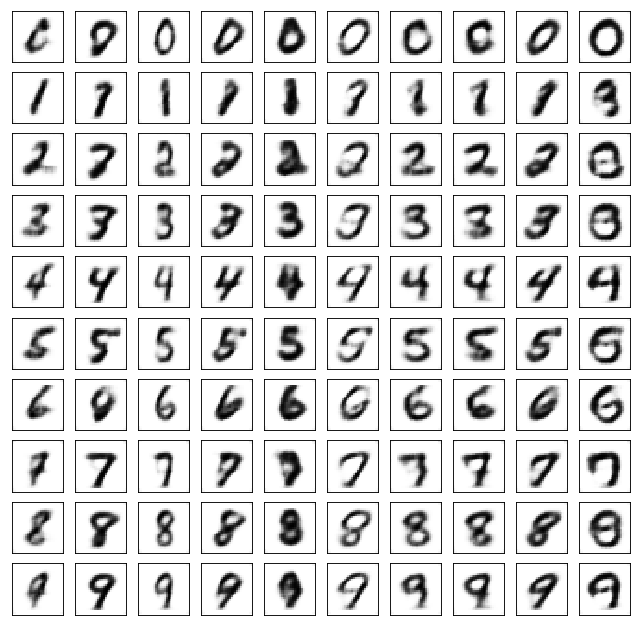

Test losses: VAE10: 0.0856/8.3798
Train Epoch: 20 [0/50000 (0%)]	Losses VAE10: 0.1010
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE10: 0.1117
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE10: 0.1016
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE10: 0.0989
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE10: 0.1075
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE10: 0.1097


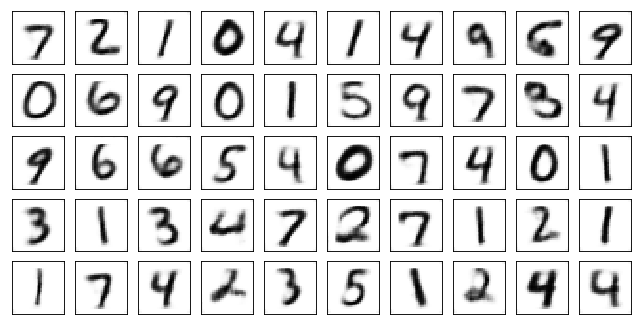


======= Decode from fixed sample =======



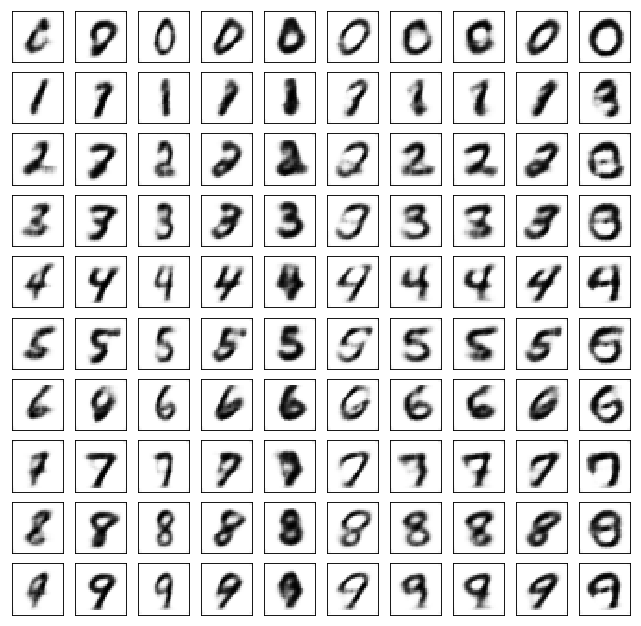

Test losses: VAE10: 0.0840/8.4407
Train Epoch: 21 [0/50000 (0%)]	Losses VAE10: 0.0983
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE10: 0.1081
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE10: 0.1202
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE10: 0.1060
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE10: 0.1143
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE10: 0.1087


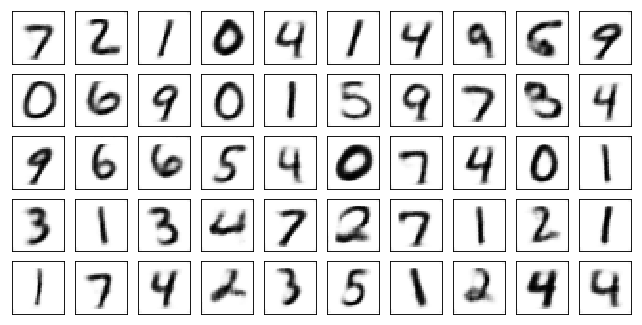


======= Decode from fixed sample =======



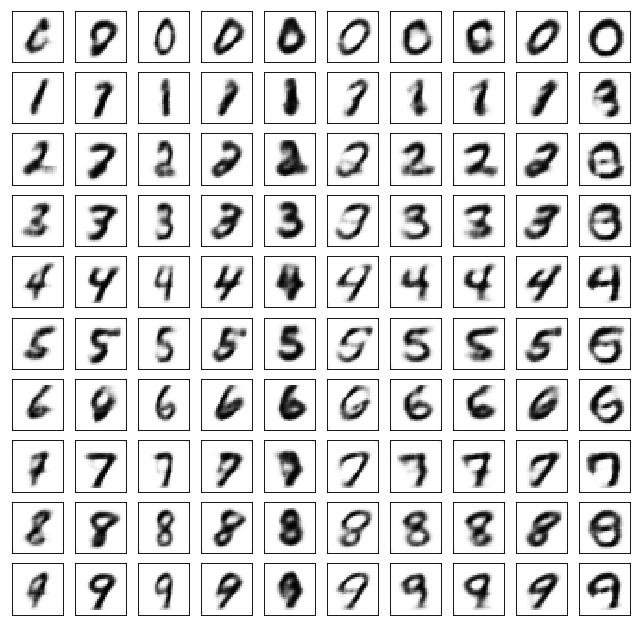

Test losses: VAE10: 0.0838/8.4087
Train Epoch: 22 [0/50000 (0%)]	Losses VAE10: 0.1123
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE10: 0.1000
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE10: 0.0930
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE10: 0.1012
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE10: 0.1000
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE10: 0.0991


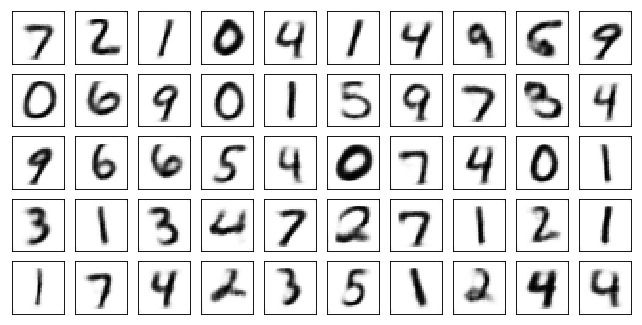


======= Decode from fixed sample =======



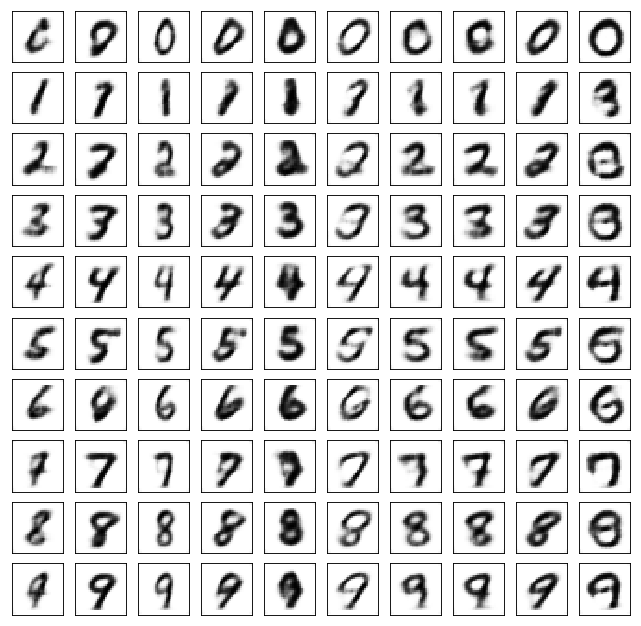

Test losses: VAE10: 0.0828/8.5763
Train Epoch: 23 [0/50000 (0%)]	Losses VAE10: 0.1097
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE10: 0.1061
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE10: 0.0982
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE10: 0.1082
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE10: 0.1137
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE10: 0.0990


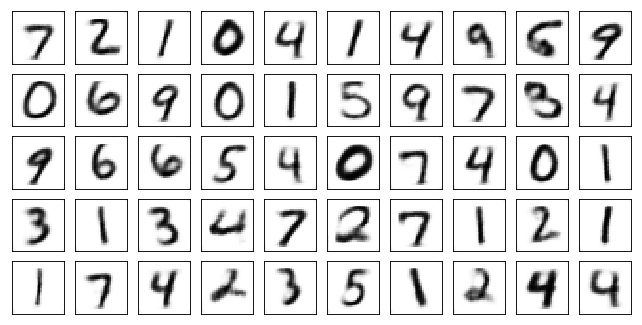


======= Decode from fixed sample =======



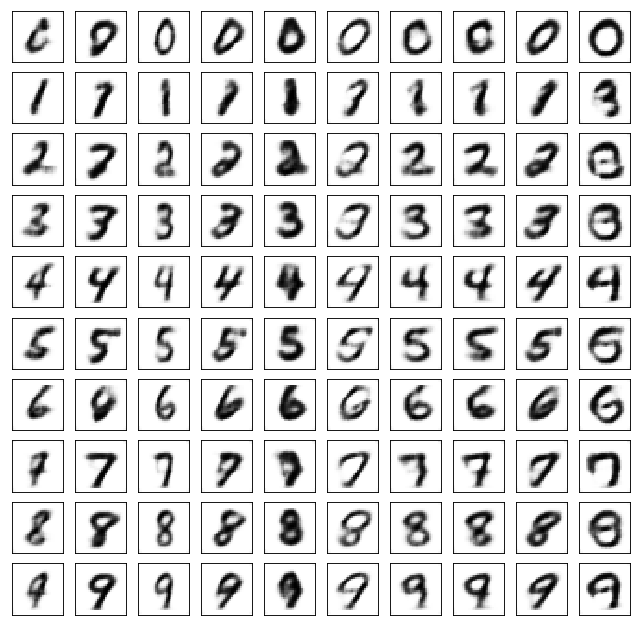

Test losses: VAE10: 0.0821/8.4183
Train Epoch: 24 [0/50000 (0%)]	Losses VAE10: 0.1047
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE10: 0.1035
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE10: 0.1015
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE10: 0.1035
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE10: 0.0959
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE10: 0.0908


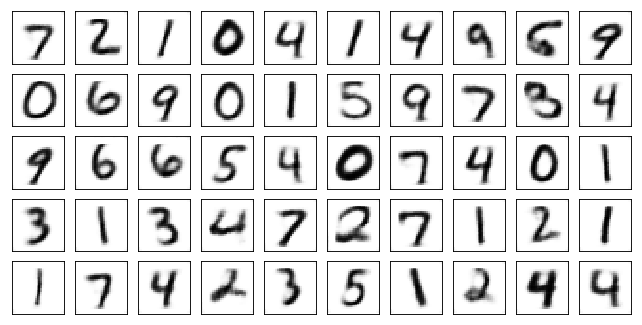


======= Decode from fixed sample =======



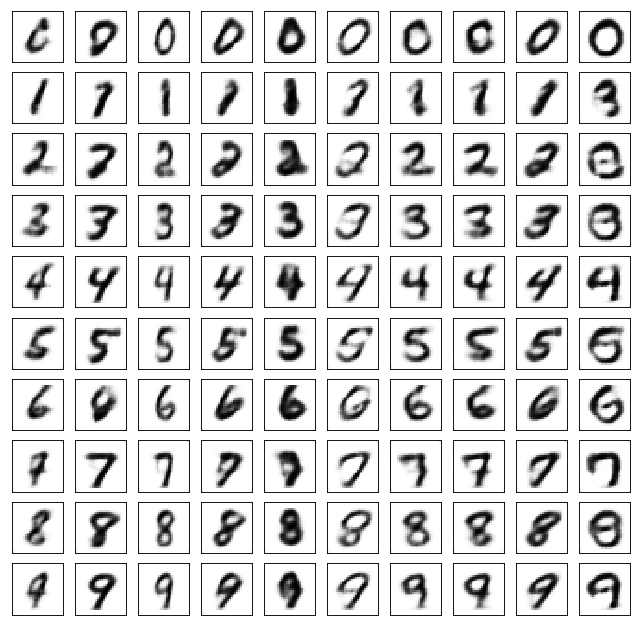

Test losses: VAE10: 0.0812/8.6640
Train Epoch: 25 [0/50000 (0%)]	Losses VAE10: 0.1065
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE10: 0.1051
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE10: 0.1026
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE10: 0.1003
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE10: 0.1000
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE10: 0.0835


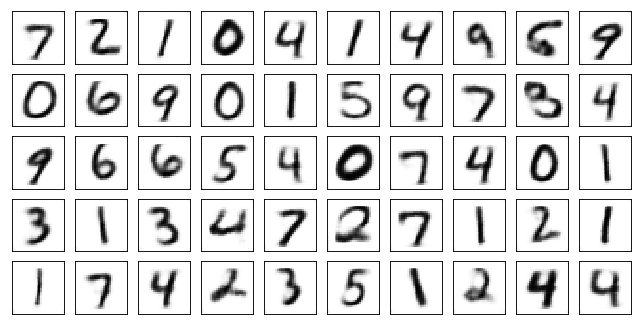


======= Decode from fixed sample =======



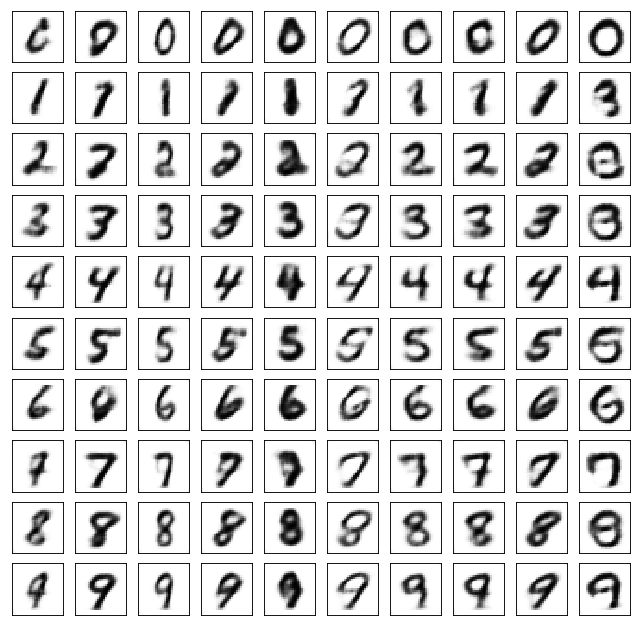

Test losses: VAE10: 0.0804/8.7762
Train Epoch: 26 [0/50000 (0%)]	Losses VAE10: 0.1084
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE10: 0.0927
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE10: 0.0933
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE10: 0.0975
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE10: 0.1026
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE10: 0.0981


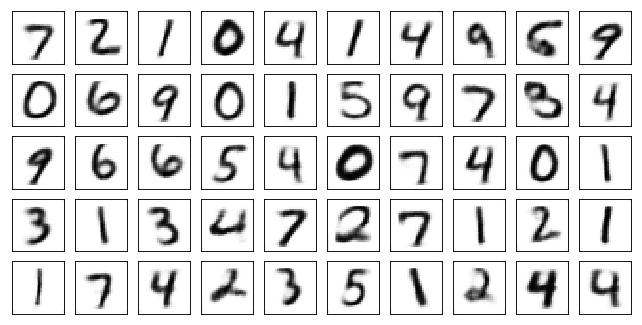


======= Decode from fixed sample =======



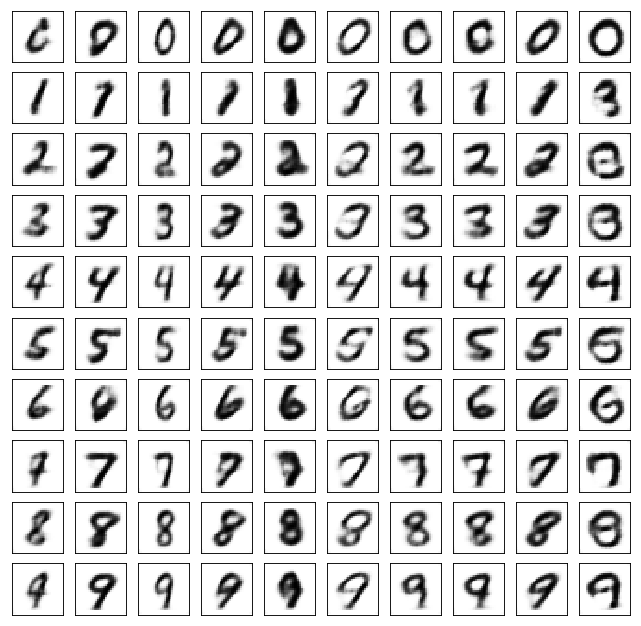

Test losses: VAE10: 0.0803/8.6548
Train Epoch: 27 [0/50000 (0%)]	Losses VAE10: 0.1081
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE10: 0.0874
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE10: 0.0980
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE10: 0.1005
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE10: 0.1036
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE10: 0.0911


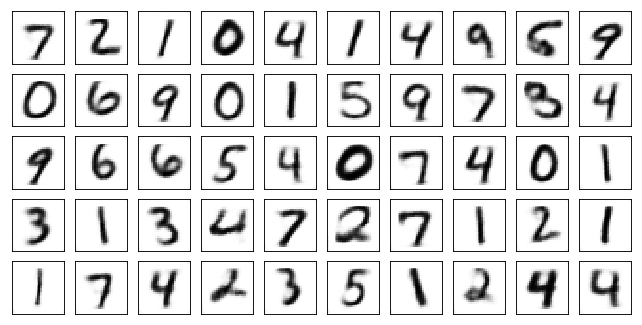


======= Decode from fixed sample =======



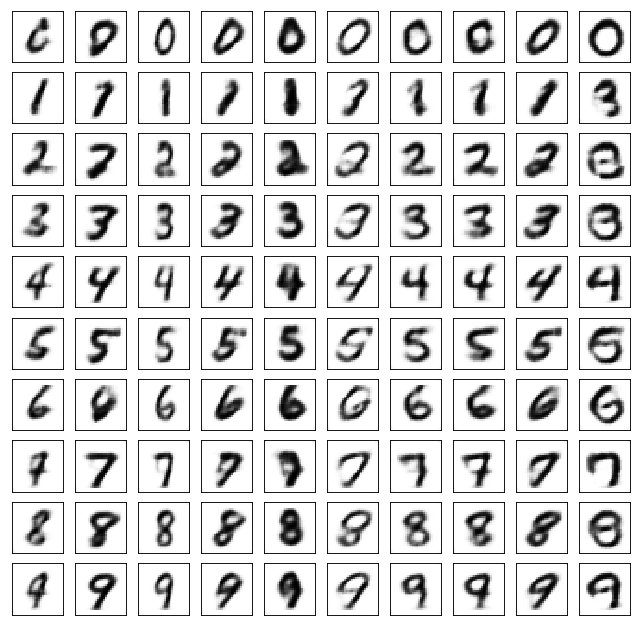

Test losses: VAE10: 0.0800/8.5558
Train Epoch: 28 [0/50000 (0%)]	Losses VAE10: 0.1021
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE10: 0.0953
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE10: 0.1076
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE10: 0.1116
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE10: 0.1016
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE10: 0.1036


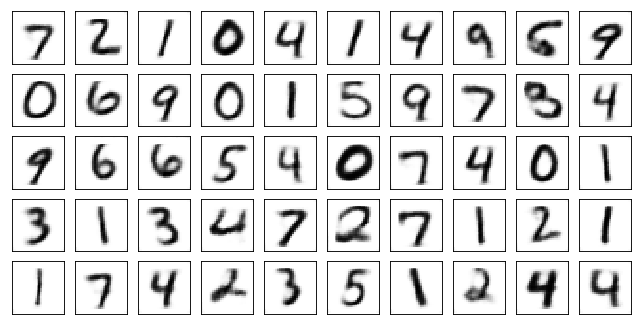


======= Decode from fixed sample =======



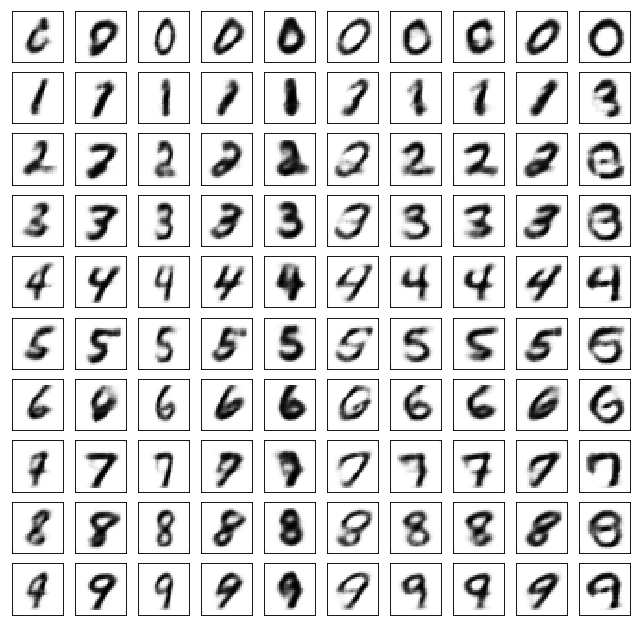

Test losses: VAE10: 0.0791/8.5052
Train Epoch: 29 [0/50000 (0%)]	Losses VAE10: 0.0931
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE10: 0.0930
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE10: 0.0922
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE10: 0.1039
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE10: 0.0926
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE10: 0.1005


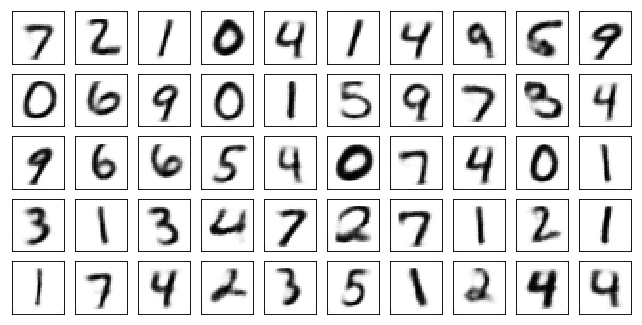


======= Decode from fixed sample =======



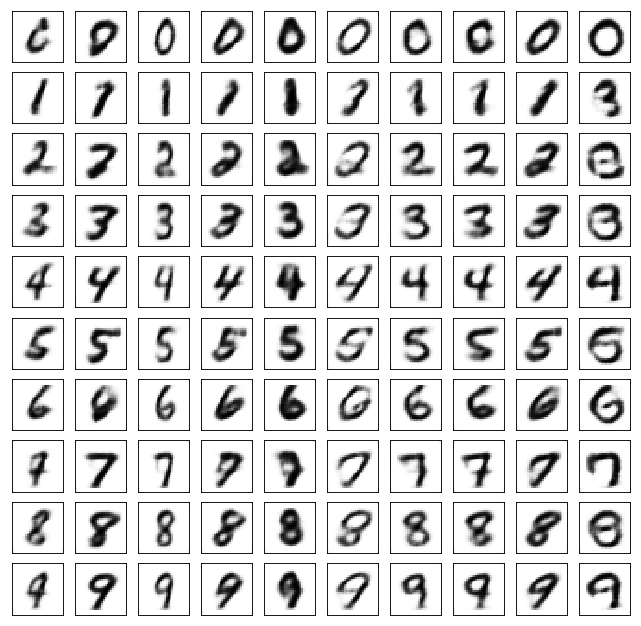

Test losses: VAE10: 0.0786/8.7185
Train Epoch: 30 [0/50000 (0%)]	Losses VAE10: 0.0974
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE10: 0.0977
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE10: 0.0825
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE10: 0.0923
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE10: 0.0855
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE10: 0.1078


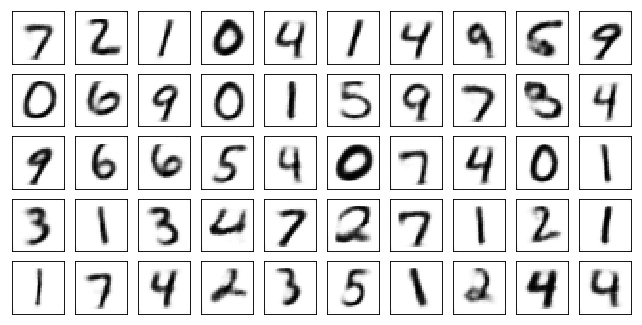


======= Decode from fixed sample =======



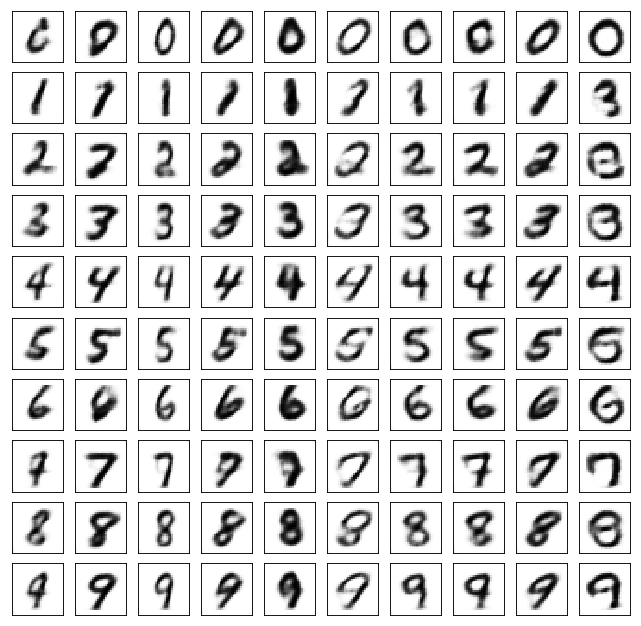

Test losses: VAE10: 0.0787/8.6308


In [15]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)